#### autoreload modules and utilities

In [1]:
%load_ext autoreload
%autoreload 2

#### import all neceesary libraries/packages

In [76]:
import numpy as np 
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 

from sklearn.pipeline import Pipeline 
from sklearn.pipeline import FeatureUnion
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import f1_score as calculate_f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

#### Utility functions

In [88]:
## utilities
# from utils import clean_text

import string
from sklearn.base import TransformerMixin

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('wordnet')


def clean_text(text: str, lemmatizer = lambda x: x) -> str:
    # removes upper cases
    text = text.lower().strip()
    
    # removes punctuation
    for char in string.punctuation:
        text = text.replace(char, " ")
    
    #lematize the words and join back into string text
    text = " ".join([lemmatizer(word) for word in word_tokenize(text)])
    return text


def data_isvalid(text, analyser, min_character_size, max_character_size):
    return min_character_size <= len(analyser(text)) <= max_character_size 


def get_pipeline(vectorizer_type, classifier, use_t2pi, min_df=3, stop_words=None, lemmatizer = lambda x: x):
    vectorizer = CountVectorizer if vectorizer_type == "count" else TfidfVectorizer
    vect = vectorizer(stop_words=stop_words, min_df=min_df)
    
    models = [
        ('clean_text', CleanTextTransformer(lemmatizer)),
    ]
    
    if use_t2pi:
        models.append(
            ("vectorizers", FeatureUnion([
                ('count_binary', CountVectorizer(stop_words=stop_words, binary=True, min_df=min_df)),
                ("count", vect)
                ])
            )
        )
        models.append(('t2pi_transformer', T2PITransformer()))
        
    else:
        models.append(('vectorizer', vect))
    
#     models.append(("scaler", StandardScaler(with_mean=False)))
    models.append(('classifier', classifier))
    return Pipeline(models)

def plot_bars(df, ylabel, ymin=0.77):
    xlabels = ["count_model", "count_sw_model", "tfidf_model", "tfidf_sw_model"]
    accuracy_means = df[["count_model", "count_sw_model", "tfidf_model", "tfidf_sw_model"]].loc["mean"]
    t2pi_accuracy_means = df[["t2pi_count_model", "t2pi_count_sw_model", "t2pi_tfidf_model", "t2pi_tfidf_sw_model"]].loc["mean"]

    xvalues = np.arange(len(xlabels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(xvalues - width/2, accuracy_means, width, label='Baseline')
    rects2 = ax.bar(xvalues + width/2, t2pi_accuracy_means, width, label='T2PI')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel.capitalize())
    ax.set_title(f'{ylabel.capitalize()} of Baseline and T2PI')
    ax.set_ylim(ymin=ymin)
    ax.set_xticks(xvalues)
    ax.set_xticklabels(xlabels)
    ax.legend()
    plt.show()

class CleanTextTransformer(TransformerMixin):
    def __init__(self, lemmatizer):
        self._lemmatizer = lemmatizer
        
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return np.vectorize(lambda x: clean_text(x, self._lemmatizer))(X)
    
    def __str__(self):
        return "CleanTextTransformer()"
    
    def __repr__(self):
        return self.__str__()
    
    
class T2PITransformer(TransformerMixin):
    @staticmethod
    def _max_weight(x, pbar, word_word_pr):
        pbar.update(1)
        return (word_word_pr.T * x).max(0)
        
    def fit(self, X, y=None, **fit_params):
        X = X[:, :int(X.shape[1]/2)].toarray()
        
        print("creating term-term co-occurence pr matrix")
        terms = np.arange(X.shape[1])
        
        X = pd.DataFrame(X, columns=terms)
        self.word_word_pr_distr = pd.DataFrame(data=0.0, columns=terms, index=terms)
        
        for term in tqdm(terms):
            self.word_word_pr_distr[term] = X[X[term] > 0].sum(0) / X.sum(0)
            
        return self

    def transform(self, X, y=None, **fit_params):
        X = X[:, int(X.shape[1]/2):].toarray()
        X = pd.DataFrame(X, columns=self.word_word_pr_distr.columns)
        
        print("transforming ...")
        with tqdm(total=X.shape[0]) as pbar:
            X = X.apply(self._max_weight, axis=1, args=(pbar, self.word_word_pr_distr))
            
        return X
    
    def __str__(self):
        return "T2PITransformer()"
    
    def __repr__(self):
        return self.__str__()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

In [100]:
# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

all_docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
categories = all_docs.target_names

In [101]:
print(all_docs.data[0])



I think that domestication will change behavior to a large degree.
Domesticated animals exhibit behaviors not found in the wild.  I
don't think that they can be viewed as good representatives of the
wild animal kingdom, since they have been bred for thousands of years
to produce certain behaviors, etc.


### Create Dataframe

In [102]:
data = pd.DataFrame(
    data={
        "text":all_docs.data, 
        "label":all_docs.target
    }
)

data.head()

,text,label
0,\n\nI think that domestication will change beh...,0
1,"\nI don't like this comment about ""Typical"" th...",3
2,\n<apparently you're not a woman - my husband ...,1
3,"While not exactly a service incident, I had a ...",1
4,\n\nI think I can. Largely as a result of effo...,2


### Label Frequency

1    594
2    593
3    564
0    480
Name: label, dtype: int64



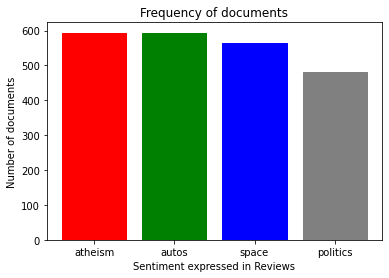

In [103]:
print(data["label"].value_counts())
print()

barlist = plt.bar(categories, data["label"].value_counts())

plt.title("Frequency of documents")
plt.xticks(categories, list(map(lambda x: x.split(".")[1], categories)))
plt.ylabel('Number of documents')
plt.xlabel('Sentiment expressed in Reviews')

barlist[0].set_color('red')
barlist[1].set_color('green')
barlist[2].set_color('blue')
barlist[3].set_color('grey')
plt.show()

The Dataset labels needs to be balanced

### Parameters

In [104]:
min_df = 3
stop_words = "english"

def get_classifier():
#     return ComplementNB()
    return MultinomialNB()
#     return BernoulliNB()
#     return LogisticRegression(random_state=0)

def get_lemmatizer():
#     return lambda x: x
    return WordNetLemmatizer().lemmatize

# Select Valid Data

In [105]:
max_size_per_class = 500

# remove long text
min_chr_size = 128
max_chr_size = 2048
indices = data["text"].apply(data_isvalid, args=(lambda x: clean_text(x, get_lemmatizer()), min_chr_size, max_chr_size))
data = data[indices]

# make classes balanced
class_indices = []

for index in range(4):
    class_indices.append(np.where((data["label"] == index))[0])
    
size_per_class = min(max_size_per_class, min(map(len, class_indices)))
indices = np.concatenate([class_ids[:size_per_class] for class_ids in class_indices])

data = data.iloc[indices]

data.head()

,text,label
0,\n\nI think that domestication will change beh...,0
6,\n \n(Deletion)\n \n \nYou have given that ex...,0
19,"\n\n\tI agree, we spend too much energy on the...",0
29,"(reference line trimmed)\n\n\n\nWell, I'd say ...",0
30,\n[rest deleted...]\n\nYou were a liberal arts...,0


In [106]:
print(data.iloc[0]["text"])



I think that domestication will change behavior to a large degree.
Domesticated animals exhibit behaviors not found in the wild.  I
don't think that they can be viewed as good representatives of the
wild animal kingdom, since they have been bred for thousands of years
to produce certain behaviors, etc.


3    366
2    366
1    366
0    366
Name: label, dtype: int64



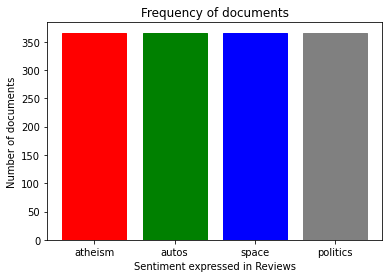

In [107]:
print(data["label"].value_counts())
print()

barlist = plt.bar(categories, data["label"].value_counts())

plt.title("Frequency of documents")
plt.xticks(categories, list(map(lambda x: x.split(".")[1], categories)))
plt.ylabel('Number of documents')
plt.xlabel('Sentiment expressed in Reviews')

barlist[0].set_color('red')
barlist[1].set_color('green')
barlist[2].set_color('blue')
barlist[3].set_color('grey')
plt.show()

### initialize input and output

In [108]:
X = data["text"]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### initialize recursive word infer model

In [109]:
# initialize model
t2pi_model = get_pipeline("count", get_classifier(), use_t2pi=True, min_df=min_df, stop_words=None, lemmatizer = get_lemmatizer())
t2pi_model

Pipeline(steps=[('clean_text', CleanTextTransformer()),
                ('vectorizers',
                 FeatureUnion(transformer_list=[('count_binary',
                                                 CountVectorizer(binary=True,
                                                                 min_df=3)),
                                                ('count',
                                                 CountVectorizer(min_df=3))])),
                ('t2pi_transformer', T2PITransformer()),
                ('classifier', MultinomialNB())])

In [110]:
# fit model
t2pi_model.fit(X_train, y_train)

creating term-term co-occurence pr matrix



transforming ...


KeyboardInterrupt: 

In [ ]:
y_pred = t2pi_model.predict(X_test) #predict testing data

print(classification_report(y_test, y_pred))

In [ ]:
print(confusion_matrix(y_test, y_pred))

### Initialize models

In [111]:
# normal model
count_model = get_pipeline("count", get_classifier(), use_t2pi=False, min_df=min_df, stop_words=None, lemmatizer = get_lemmatizer())
count_sw_model = get_pipeline("count", get_classifier(), use_t2pi=False, min_df=min_df, stop_words=stop_words, lemmatizer = get_lemmatizer())

tfidf_model = get_pipeline("tfidf", get_classifier(), use_t2pi=False, min_df=min_df, stop_words=None, lemmatizer = get_lemmatizer())
tfidf_sw_model = get_pipeline("tfidf", get_classifier(), use_t2pi=False, min_df=min_df, stop_words=stop_words, lemmatizer = get_lemmatizer())

# model
t2pi_count_model = get_pipeline("count", get_classifier(), use_t2pi=True, min_df=min_df, stop_words=None, lemmatizer = get_lemmatizer())
t2pi_count_sw_model = get_pipeline("count", get_classifier(), use_t2pi=True, min_df=min_df, stop_words=stop_words, lemmatizer = get_lemmatizer())

t2pi_tfidf_model = get_pipeline("tfidf", get_classifier(), use_t2pi=True, min_df=min_df, stop_words=None, lemmatizer = get_lemmatizer())
t2pi_tfidf_sw_model = get_pipeline("tfidf", get_classifier(), use_t2pi=True, min_df=min_df, stop_words=stop_words, lemmatizer = get_lemmatizer())

models = {
    "count_model": count_model, 
    "count_sw_model": count_model, 
    "tfidf_model": tfidf_model,
    "tfidf_sw_model": tfidf_sw_model, 
    "t2pi_count_model": t2pi_count_model,
    "t2pi_count_sw_model": t2pi_count_sw_model, 
    "t2pi_tfidf_model": t2pi_tfidf_model, 
    "t2pi_tfidf_sw_model": t2pi_tfidf_sw_model
}

### Running Cross validation on all Models

In [112]:
split_size = 3
skf = StratifiedKFold(n_splits=split_size, shuffle=True, random_state=100) 

index = 0
macro_f1_scores, weighted_f1_scores, accuracies = [], [], []

for train_index, test_index in skf.split(X, y):
    index += 1
    
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index] 
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    accuracies.append([])
    macro_f1_scores.append([])
    weighted_f1_scores.append([])
    
    for model_name, model in models.items():
        print(f'-> {index}. {model_name} \n{"="*100}\n')
        model.fit(x_train_fold, y_train_fold)
        y_pred = model.predict(x_test_fold)

        accuracy = accuracy_score(y_test_fold, y_pred)
        weighted_f1_score = calculate_f1_score(y_test_fold, y_pred, average='weighted')
        macro_f1_score = calculate_f1_score(y_test_fold, y_pred, average='macro')
        
        weighted_f1_scores[-1].append(weighted_f1_score)
        macro_f1_scores[-1].append(macro_f1_score)
        accuracies[-1].append(accuracy)

-> 1. count_model 

-> 1. count_sw_model 

-> 1. tfidf_model 

-> 1. tfidf_sw_model 

-> 1. t2pi_count_model 

creating term-term co-occurence pr matrix



transforming ...



transforming ...



-> 1. t2pi_count_sw_model 

creating term-term co-occurence pr matrix



transforming ...



transforming ...



-> 1. t2pi_tfidf_model 

creating term-term co-occurence pr matrix



transforming ...



transforming ...



-> 1. t2pi_tfidf_sw_model 

creating term-term co-occurence pr matrix



transforming ...



transforming ...



-> 2. count_model 

-> 2. count_sw_model 

-> 2. tfidf_model 

-> 2. tfidf_sw_model 

-> 2. t2pi_count_model 

creating term-term co-occurence pr matrix



transforming ...



transforming ...



-> 2. t2pi_count_sw_model 

creating term-term co-occurence pr matrix



transforming ...



transforming ...



-> 2. t2pi_tfidf_model 

creating term-term co-occurence pr matrix



transforming ...



transforming ...



-> 2. t2pi_tfidf_sw_model 

creating term-term co-occurence pr matrix



transforming ...



transforming ...



-> 3. count_model 

-> 3. count_sw_model 

-> 3. tfidf_model 

-> 3. tfidf_sw_model 

-> 3. t2pi_count_model 

creating term-term co-occurence pr matrix



transforming ...



transforming ...



-> 3. t2pi_count_sw_model 

creating term-term co-occurence pr matrix



transforming ...



transforming ...



-> 3. t2pi_tfidf_model 

creating term-term co-occurence pr matrix



transforming ...



transforming ...



-> 3. t2pi_tfidf_sw_model 

creating term-term co-occurence pr matrix



transforming ...



transforming ...


In [113]:
model_names = list(models.keys())

accuracy = pd.DataFrame(data=np.array(accuracies), columns=model_names)
weighted_f1_score = pd.DataFrame(data=np.array(weighted_f1_scores), columns=model_names)
macro_f1_score = pd.DataFrame(data=np.array(macro_f1_scores), columns=model_names)

accuracy.loc["mean"] = accuracy.mean(0)
weighted_f1_score.loc["mean"] = weighted_f1_score.mean(0)
macro_f1_score.loc["mean"] = macro_f1_score.mean(0)

In [114]:
accuracy.head(split_size+1)

,count_model,count_sw_model,tfidf_model,tfidf_sw_model,t2pi_count_model,t2pi_count_sw_model,t2pi_tfidf_model,t2pi_tfidf_sw_model
0,0.907787,0.907787,0.895492,0.905738,0.907787,0.903689,0.895492,0.905738
1,0.868852,0.868852,0.870902,0.866803,0.868852,0.868852,0.870902,0.866803
2,0.879098,0.879098,0.864754,0.889344,0.879098,0.887295,0.864754,0.889344
mean,0.885246,0.885246,0.877049,0.887295,0.885246,0.886612,0.877049,0.887295


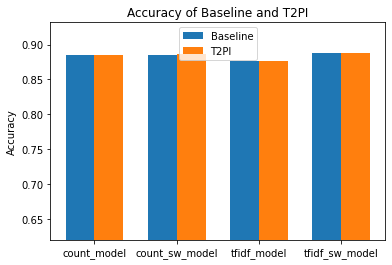

In [115]:
plot_bars(accuracy, ylabel="accuracy", ymin=0.62)

In [116]:
weighted_f1_score.head(split_size+1)

,count_model,count_sw_model,tfidf_model,tfidf_sw_model,t2pi_count_model,t2pi_count_sw_model,t2pi_tfidf_model,t2pi_tfidf_sw_model
0,0.907712,0.907712,0.895567,0.905502,0.907712,0.903616,0.895567,0.905502
1,0.869463,0.869463,0.872407,0.866824,0.869463,0.869027,0.872407,0.866824
2,0.879298,0.879298,0.865577,0.889414,0.879298,0.887347,0.865577,0.889414
mean,0.885491,0.885491,0.877850,0.887247,0.885491,0.886663,0.877850,0.887247


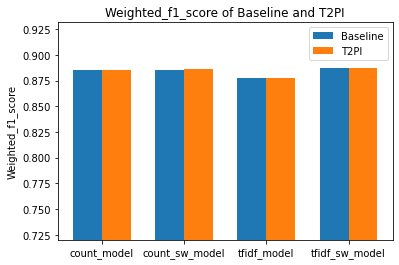

In [117]:
plot_bars(weighted_f1_score, ylabel="weighted_f1_score", ymin=0.72)

In [118]:
macro_f1_score.head(split_size+1)

,count_model,count_sw_model,tfidf_model,tfidf_sw_model,t2pi_count_model,t2pi_count_sw_model,t2pi_tfidf_model,t2pi_tfidf_sw_model
0,0.907712,0.907712,0.895567,0.905502,0.907712,0.903616,0.895567,0.905502
1,0.869463,0.869463,0.872407,0.866824,0.869463,0.869027,0.872407,0.866824
2,0.879298,0.879298,0.865577,0.889414,0.879298,0.887347,0.865577,0.889414
mean,0.885491,0.885491,0.877850,0.887247,0.885491,0.886663,0.877850,0.887247


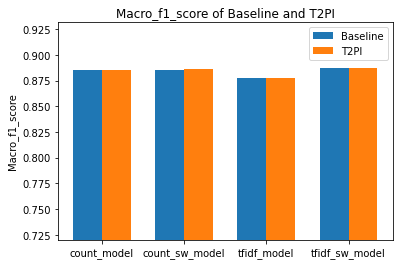

In [119]:
plot_bars(macro_f1_score, ylabel="macro_f1_score", ymin=0.72)